In [1]:
import os
import torch
import feather
import pandas as pd 
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.decomposition import PCA
import seaborn as sns


from torch.utils.data import DataLoader

from cplAE_MET.utils.dataset import MET_exc_inh, MET_exc_inh_v1
from cplAE_MET.models.torch_utils import MET_dataset_v1
from cplAE_MET.models.model_classes import Model_ME_T_v1, Model_ME_T
from cplAE_MET.utils.load_config import load_config
from cplAE_MET.models.torch_utils import MET_dataset, tonumpy
from cplAE_MET.utils.plots import plot_m, plot_z, plot_z_3d
from cplAE_MET.utils.utils import loadpkl

/home/fahimehb/miniconda3/envs/cplae_met/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def set_paths(config_file=None):
    paths = load_config(config_file=config_file, verbose=False)

    paths['input'] = f'{str(paths["data_dir"])}'
    paths['arbor_density_file'] = f'{paths["input"]}/{str(paths["arbor_density_file"])}'
    paths['arbor_density_PC_file'] = f'{paths["input"]}/{str(paths["arbor_density_PC_file"])}'
    paths['arbor_density_PC_vars_file'] = f'{paths["input"]}/{str(paths["arbor_density_PC_vars_file"])}'

    paths['specimen_ids'] = f'{paths["input"]}/{str(paths["specimen_ids_file"])}'
    paths['gene_file'] = f'{paths["input"]}/{str(paths["gene_file"])}'

    paths['t_anno'] = f'{paths["input"]}/{"anno.feather"}'
    paths['t_data'] = f'{paths["input"]}/{"data.feather"}'
    paths['t_data_output'] = f'{paths["input"]}/{str(paths["t_data_output_file"])}'
    paths['t_anno_output'] = f'{paths["input"]}/{str(paths["t_anno_output_file"])}'
    paths['gene_id_output'] = f'{paths["input"]}/{str(paths["gene_id_output_file"])}'

    paths['m_data_folder'] = f'{paths["input"]}/{str(paths["m_data_folder"])}'
    paths['m_anno'] = f'{paths["m_data_folder"]}/{str(paths["m_anno"])}'
    paths['hist2d_120x4'] = f'{paths["m_data_folder"]}/{str(paths["hist2d_120x4_folder"])}'
    paths['E_timeseries'] = f'{paths["input"]}/{str(paths["E_timeseries_file"])}'
    paths['ipfx_features'] = f'{paths["input"]}/{str(paths["ipfx_features_file"])}'
    paths['e_output'] = f'{paths["input"]}/{str(paths["e_output_file"])}'
    paths['met_output'] = f'{paths["input"]}/{str(paths["met_output_file"])}'
    return paths

In [3]:
dir_pth = set_paths("config_preproc.toml")

Lets read the Patch-seq, ME and fMOST cell specimen ids:

In [4]:
aspiny_me = pd.read_csv("/home/fahimehb/Remote-AI-root/allen/programs/celltypes/workgroups/mousecelltypes/MachineLearning/Olga/morphology/arbor_density_ae/ME_cells/aspiny203.csv")['specimen_id'].to_list()
spiny_me = pd.read_csv("/home/fahimehb/Remote-AI-root/allen/programs/celltypes/workgroups/mousecelltypes/MachineLearning/Olga/morphology/arbor_density_ae/ME_cells/spiny244.csv")['specimen_id'].to_list()
original_me_cells = aspiny_me + spiny_me
original_me_cells = [str(i) for i in original_me_cells]
print("total_number of original me cells:", len(original_me_cells))

spiny_fmost_cells = pd.read_csv("/home/fahimehb/Remote-AI-root/allen/programs/celltypes/workgroups/mousecelltypes/MachineLearning/Olga/morphology/arbor_density_ae/full_morphology/spiny141.csv")['specimen_id'].to_list()
print("total_number of fmost  cells:", len(spiny_fmost_cells))

t_anno = feather.read_dataframe(dir_pth['t_anno'])
locked_sids = pd.read_csv(dir_pth['specimen_ids'])['specimen_id'].to_list()
patchseq_cells = [i for i in locked_sids if i not in spiny_fmost_cells + original_me_cells]
print("total_number of patchseq cells:", len(patchseq_cells))
print("In total we have this number of cells: ", len(patchseq_cells) + len(spiny_fmost_cells) + len(original_me_cells))


total_number of original me cells: 447
total_number of fmost  cells: 141
total_number of patchseq cells: 6570
In total we have this number of cells:  7158


In [5]:
# read input mat file 
paths = load_config(config_file="config.toml", verbose=False)
dat = MET_exc_inh.from_file(paths['MET_data'])
dataset = MET_dataset(dat, device='cpu')
dataloader = DataLoader(dataset, batch_size=dataset.xt.shape[0], shuffle=False, drop_last=False)
for _, data in enumerate(iter(dataloader)):
    print ("done!")

is_t_1d = tonumpy(data['is_t_1d'])
is_e_1d = tonumpy(data['is_e_1d'])
is_m_1d = tonumpy(data['is_m_1d'])
is_me_1d = np.logical_and(is_m_1d, is_e_1d)
is_mt_1d = np.logical_and(is_m_1d, is_t_1d)
is_te_1d = np.logical_and(is_t_1d, is_e_1d)
is_met_1d = np.logical_and(is_me_1d, is_t_1d)
is_me_only = np.logical_and(is_me_1d, ~is_t_1d)

done!


In the patchseq data, we have 60 cells that are poorQ. We use their other modalities if available!

In [6]:
t_anno = feather.read_dataframe(dir_pth['t_anno'])
Counter(t_anno[t_anno['spec_id_label'].isin(patchseq_cells)]['Tree_call_label'])

Counter({'Core': 3832, 'I1': 1273, 'PoorQ': 60, 'I2': 1260, 'I3': 145})

For this, I extract their specimen ids

In [7]:
poorq_patchseq_sids = t_anno[(t_anno['spec_id_label'].isin(patchseq_cells)) & (t_anno['Tree_call_label']=="PoorQ")]['spec_id_label'].to_list()
len(poorq_patchseq_sids)

60

Now lets see if we have E or M data available for these poorQ cells

In [8]:
E_dat = tonumpy(data['xe'])
E_dat = pd.DataFrame(E_dat)
E_dat['specimen_id'] = [i.rstrip() for i in dat.specimen_id]
E_dat.head()

,0,1,2,3,4,5,6,7,8,9,...,74,75,76,77,78,79,80,81,82,specimen_id
0,-0.999557,-0.172500,0.106293,-0.098688,-0.251137,-0.067284,0.011071,-0.010887,-0.245380,-0.015951,...,-1.277001,0.160984,0.372264,0.285616,-1.067313,3.327398,0.372264,-0.179945,-1.282756,823231829
1,-0.620859,-0.167132,0.012505,0.336425,-0.413556,-0.035874,-0.121801,0.081233,-0.064271,-0.076462,...,-2.859252,0.038112,-0.414306,1.630364,0.849981,0.047901,-0.414306,0.615824,2.457034,893406540
2,-0.306119,-0.584637,0.448810,0.098134,-0.071626,-0.089518,0.042064,0.066566,0.030282,0.065689,...,-0.950055,0.754534,0.147530,0.601308,-1.868858,1.175228,0.147530,-0.149720,-0.550871,896877084
3,-0.729216,0.518118,0.538004,-0.173470,-0.186679,0.024186,-0.163281,0.017128,-0.061875,0.064795,...,-1.315300,0.523120,0.821732,0.332359,-1.063595,2.097586,0.821732,-0.266553,-1.238182,912008949
4,-0.728244,0.351255,-0.312762,0.279478,-0.019744,-0.767089,-0.180299,0.103120,-0.298261,-0.116407,...,-1.139825,0.722382,0.484631,0.070305,-0.641960,5.889505,0.484631,0.086629,-1.452191,921685533


In [9]:
E_dat[E_dat['specimen_id'].isin(poorq_patchseq_sids)].head()

,0,1,2,3,4,5,6,7,8,9,...,74,75,76,77,78,79,80,81,82,specimen_id
6510,-0.712551,0.190091,0.326434,-0.054185,-0.247339,-0.027054,-0.092966,0.004190,-0.077901,-0.048730,...,-0.684894,0.390653,-0.189572,-0.768727,-0.867731,1.516842,-0.189572,0.312977,-1.444159,924670094
6511,-0.595508,0.176303,0.053383,0.288185,-0.166862,0.033072,-0.002852,-0.055201,-0.068005,-0.031389,...,-0.786854,-0.437177,1.608301,0.056513,-0.605593,1.585165,1.608301,-0.242060,-1.086379,973464830
6512,0.240295,-0.336711,0.253186,-0.000955,0.323388,0.060052,0.062465,-0.006465,-0.019665,0.077398,...,0.850633,-0.005255,-1.088508,-0.264541,-0.120174,-0.840297,-1.088508,0.545847,1.254515,830434392
6513,0.828589,0.148901,-0.494054,0.403873,-0.422881,0.829068,-0.142902,-0.215444,0.239266,0.558600,...,-1.464055,0.943079,2.956705,1.059518,0.042764,0.867775,2.956705,-0.448213,-0.228589,818023203
6514,-0.345351,-0.441126,0.157806,0.119752,0.062009,0.014203,0.012200,0.044280,0.060543,-0.002979,...,-0.788709,-0.252245,0.596998,-0.370282,1.144626,1.277712,0.596998,-0.117094,-1.362900,916494155


In [10]:
#patchseq details
patchseq_cells_1d = np.array([True if i.rstrip() in patchseq_cells else False for i in dat.specimen_id])

patchseq_t_only = np.logical_and(is_t_1d, np.logical_and(~is_m_1d, ~is_e_1d))
patchseq_te_only = np.logical_and(~is_m_1d, np.logical_and(is_t_1d, is_e_1d))
patchseq_mt_only = np.logical_and(~is_e_1d, np.logical_and(is_t_1d, is_m_1d))
patchseq_met_only = np.logical_and(is_e_1d, np.logical_and(is_t_1d, is_m_1d))

patchseq_m_or_e = np.logical_and(patchseq_cells_1d, ~is_t_1d)
patchseq_m_only = np.logical_and(~is_e_1d, np.logical_and(patchseq_m_or_e, is_m_1d))
patchseq_e_only = np.logical_and(~is_m_1d, np.logical_and(patchseq_m_or_e, is_e_1d))
patchseq_me_only = np.logical_and(~is_t_1d, np.logical_and(patchseq_m_or_e, is_me_1d))


print(patchseq_t_only.sum(), patchseq_te_only.sum(), patchseq_mt_only.sum(), patchseq_met_only.sum(), patchseq_m_only.sum(), patchseq_e_only.sum(), patchseq_me_only.sum())
print(patchseq_t_only.sum()+ patchseq_te_only.sum()+ patchseq_mt_only.sum()+ patchseq_met_only.sum()+ patchseq_m_only.sum()+ patchseq_e_only.sum()+ patchseq_me_only.sum())

554 4441 102 1413 2 0 58
6570


In [11]:
#me details
me_cells_1d = np.array([True if i.rstrip() in original_me_cells else False for i in dat.specimen_id])
me_cells_1d.sum()


447

In [12]:
#fmost details
spiny_fmost_cells_1d = np.array([True if i.rstrip() in spiny_fmost_cells else False for i in dat.specimen_id])
spiny_fmost_cells_1d.sum()

141

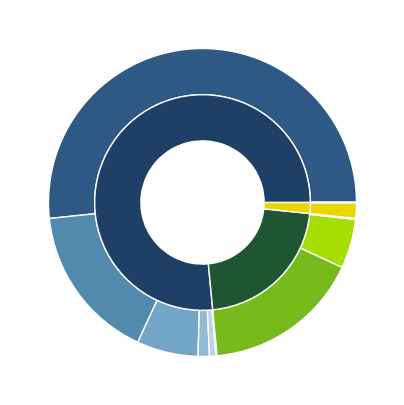

In [13]:

fig, ax = plt.subplots(figsize=(5,5))

size = 0.3
vals = np.array([[4441, 1413, 554, 102, 58, 10], [1424, 444, 10 ,0, 0, 0], [141,0,0,0, 0, 0]])

cmap = plt.colormaps["tab20c"]
outer_colors = ["#1E3F66", "#1E5631", "#e9d700"]
inner_colors = ["#2E5984","#528AAE",  "#73A5C6", "#91BAD6", "#BCD2E8", "#1E3F66","#76BA1B", "#A4DE02", "#1E5631", "#FFDAB9","#e9d700","#e9d700", "#e9d700", "#e9d700","#e9d700","#e9d700"]

labels_inner = ["T & E", "M & E & T", "T", "M & T", "M & E", "M & E", "M & E", "M & E", "M", "M", "M", "M"]
labels_outer = ["Patchseq cells", "ME cells", "Fmost cells"]

ax.pie(vals.flatten(), radius=1, colors=inner_colors, 
       wedgeprops=dict(width=size, edgecolor='w'))

ax.pie(vals.sum(axis=1), radius=1-size, colors=outer_colors,
       wedgeprops=dict(width=size, edgecolor='w'))

# plt.title("Dataset overviews")

plt.show()

In [14]:
# fig.savefig("/home/fahimehb/Local/new_codes/cplAE_MET/data/results/Figure/pie_chart.pdf")

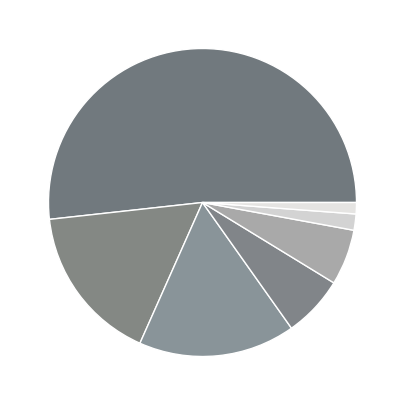

In [15]:
fig, ax = plt.subplots(figsize=(5,5))

y = np.array([patchseq_te_only.sum(), 1424, patchseq_met_only.sum(), patchseq_t_only.sum(), patchseq_me_only.sum() + 444, 146, patchseq_mt_only.sum()])
colors= ["#71797E", "#848884", "#899499", "#818589", "#A9A9A9", "#D3D3D3", "#E5E4E2"]
plt.pie(y, colors=colors)
plt.show() 

In [16]:
# fig.savefig("/home/fahimehb/Local/new_codes/cplAE_MET/data/results/Figure/pie_chart2.pdf")

Text(0.5, 0, 'M features(xm)')

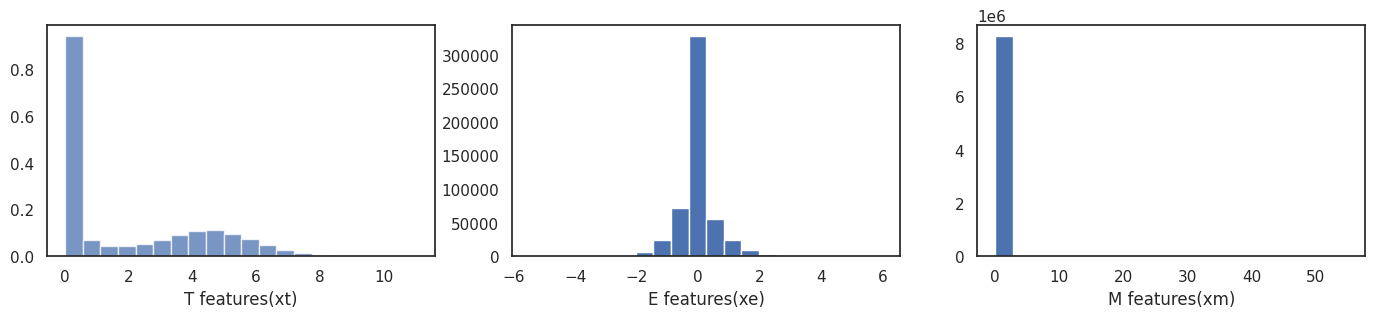

In [17]:
# input data histograms
fig, axs = plt.subplots(1,3, figsize=(17, 3))
_ = axs[0].hist(tonumpy(data['xt'][data['valid_xt']]), bins=20, density=True, alpha=0.75)
_ = axs[1].hist(tonumpy(data['xe'][data['valid_xe']]), bins=20)
_ = axs[2].hist(tonumpy(data['xm'][data['valid_xm']]), bins=20)
axs[0].set_xlabel("T features(xt)")
axs[1].set_xlabel("E features(xe)")
axs[2].set_xlabel("M features(xm)")

In [18]:
pd.DataFrame(tonumpy(data['xt']), columns=dat.gene_ids)

,Lhx6,Gad2,Slc32a1,Neurod2,Slc6a1,Gad1,Adarb2,Sv2b,Nrn1,Slc17a7,...,Adrb1,Chst1,Trps1,2610100L16Rik,Gnaz,Pth2r,Ier5l,Cmya5,Coro2a,Spsb4
0,0.0,0.00000,0.0,3.314892,4.151198,0.0,0.000000,5.927228,4.655706,6.119575,...,2.348631,4.836442,3.083591,0.000000,3.684671,0.0,0.666352,3.166779,1.566215,0.0
1,0.0,1.09609,0.0,4.450605,0.000000,0.0,0.000000,5.575958,4.427076,5.620245,...,3.824938,4.611372,4.518044,5.489291,3.174426,0.0,1.788606,0.000000,0.000000,0.0
2,0.0,0.00000,0.0,1.876337,4.836025,0.0,2.287194,3.990531,6.000302,4.389814,...,3.392951,5.331264,0.000000,0.000000,3.948775,0.0,5.442543,0.000000,0.000000,0.0
3,0.0,0.00000,0.0,4.127892,0.000000,0.0,0.654902,5.706064,5.200518,5.278958,...,4.567160,1.547524,4.365595,4.279738,2.970368,0.0,2.759964,2.128189,3.257087,0.0
4,0.0,0.00000,0.0,4.668216,4.640049,0.0,0.000000,5.554353,6.490263,5.954698,...,2.184749,4.355581,4.845876,3.318664,3.993544,0.0,0.000000,0.000000,3.747483,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7153,0.0,0.00000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0
7154,0.0,0.00000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0
7155,0.0,0.00000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0
7156,0.0,0.00000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0


<AxesSubplot: >

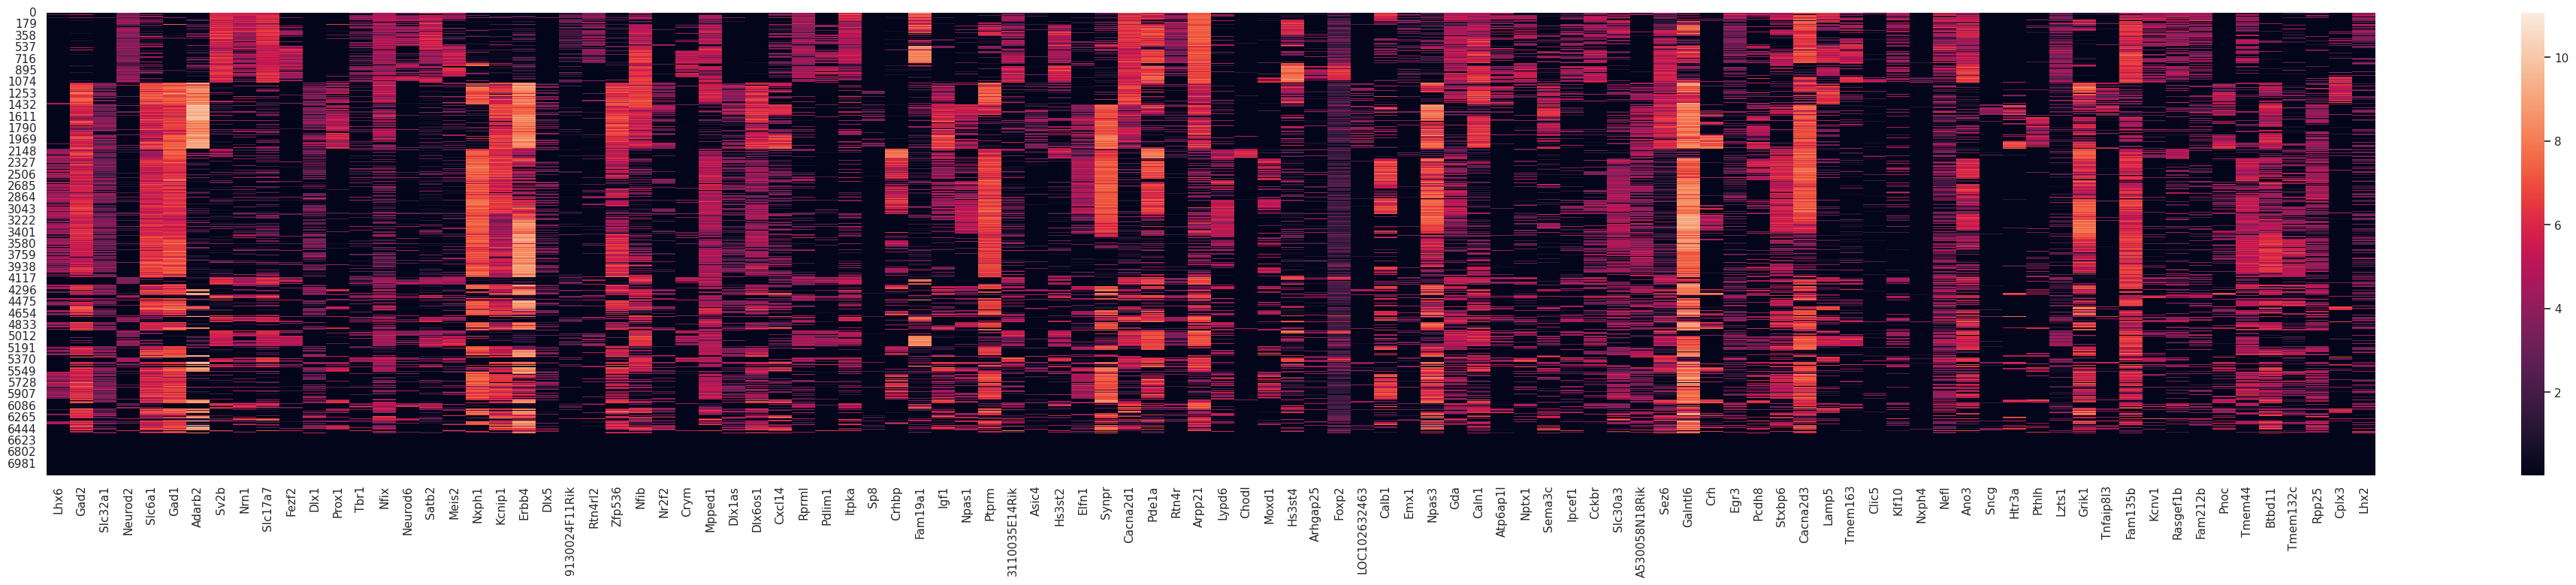

In [19]:
fig = plt.figure(figsize=(50,8))
sns.heatmap(pd.DataFrame(tonumpy(data['xt'][:,0:100]), columns=dat.gene_ids[0:100]), vmin=0.01)


### This is a run when we used the arbor density PCs as features in the M autoencoder

/home/fahimehb/Local/new_codes/cplAE_MET/cplAE_MET/utils/plots.py:233: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=["-2", "" , "-1", "", "0", "", "1",""])
/home/fahimehb/Local/new_codes/cplAE_MET/cplAE_MET/utils/plots.py:234: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels=["-1", "" , "0", "", "1", "", "2",""])
/home/fahimehb/Local/new_codes/cplAE_MET/cplAE_MET/utils/plots.py:262: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


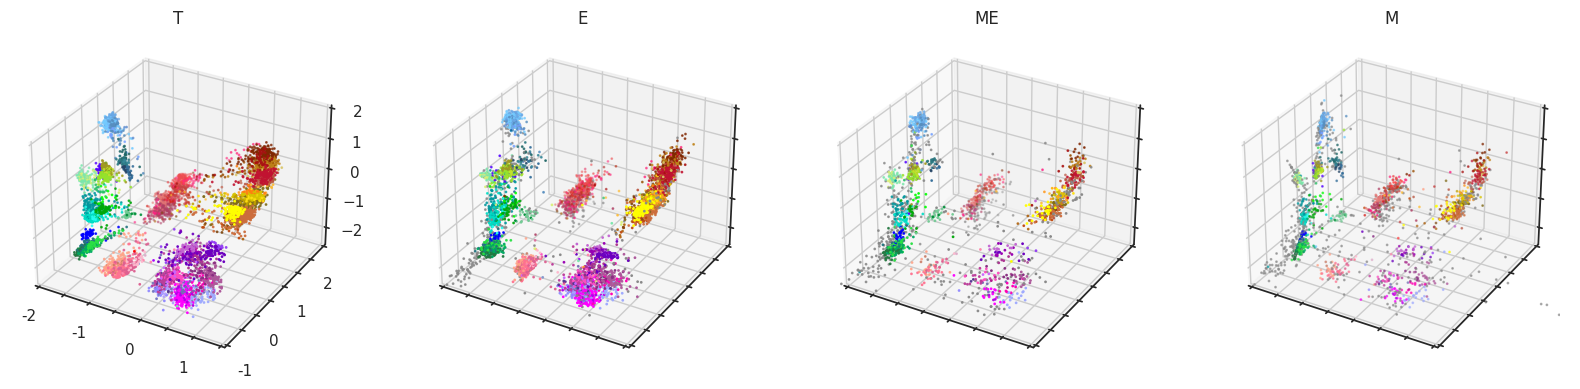

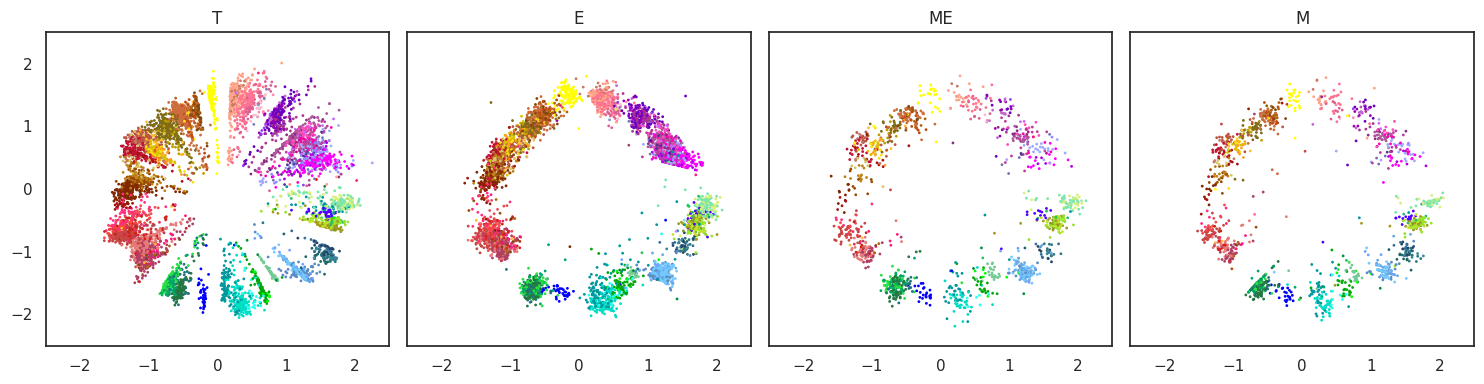

In [25]:
folder = "/home/fahimehb/Local/new_codes/cplAE_MET/data/results/all_connected_80MscaledPCs_83EPCs"
file= "checkpoint_ep_34000_test.pkl"
path = os.path.join(folder, file)
output = loadpkl(path) 
plot_z_3d(output, xlim=(-2, 1.5), ylim=(-1, 2.5), zlim=(-2.5,2))

folder = "/home/fahimehb/Local/new_codes/cplAE_MET/data/results/all_connected_80M_scaled_PCs_83EPCs_no_noise_no_drp"
file= "checkpoint_ep_35000_test.pkl"
path = os.path.join(folder, file)
output = loadpkl(path) 
plot_z(output, xlim=(-2.5, 2.5), ylim=(-2.5, 2.5))

In [24]:
# read input mat file 
dat = MET_exc_inh_v1.from_file("/home/fahimehb/Remote-AI-root/allen/programs/celltypes/workgroups/mousecelltypes/MachineLearning/Patchseq-Exc/dat/MET_data_6Dec22_80MscaledPCs.mat")
dataset = MET_dataset_v1(dat, device='cpu')
train_ind, val_ind = dat.train_val_split(fold=0, n_folds=10, seed=0)
val_ids = [i.rstrip() for i in dat.specimen_id[val_ind]]

arbor_density_PC_vars = np.array(pd.read_csv(dir_pth['arbor_density_PC_vars_file']))[0]
m_input = sio.loadmat(dir_pth['arbor_density_file'])['hist_ax_de_api_bas']
m_input_sid = pd.read_csv(dir_pth['specimen_ids'])['specimen_id'].to_list()
m_input_val_ind = [m_input_sid.index(i) for i in val_ids]

========================= Original data =============================


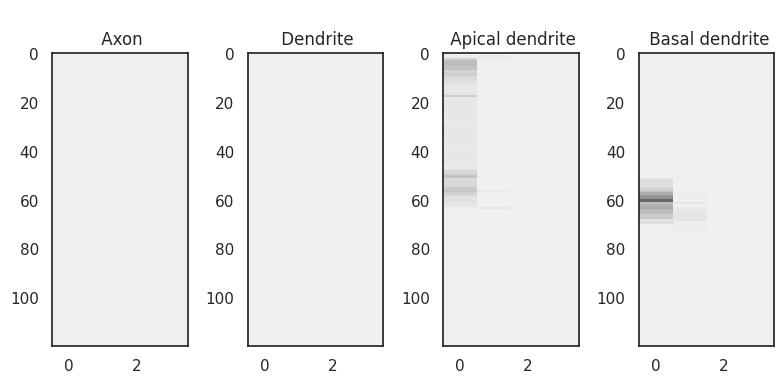

================= reconstructed data from PCs =====================


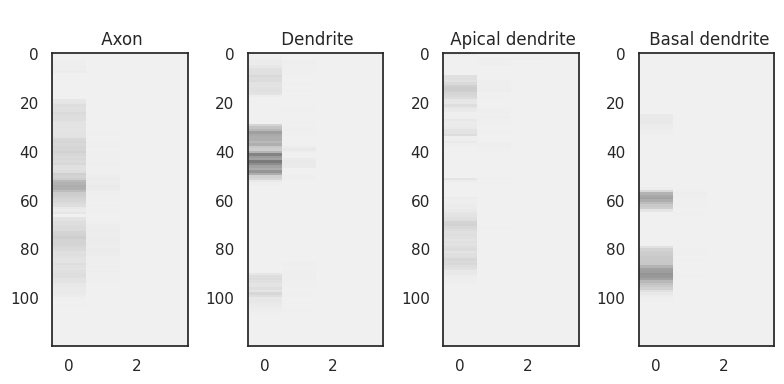

In [22]:
X_train = m_input[m_input_val_ind]
X_train_PC = output['XrM'][val_ind]
X_train = X_train.reshape(125, 480, 4)
X_projected = np.zeros((125, 480, 4))

for c in range(4):
    pca = PCA(20)
    _ = pca.fit_transform(X_train[...,c]) 
    X_projected[...,c] = pca.inverse_transform(X_train_PC[:,c*20:c*20+20] * arbor_density_PC_vars[c])

X_projected = X_projected.reshape(125, 120, 4, 4)
X_train = X_train.reshape(125, 120, 4, 4)

print("========================= Original data =============================")
plot_m(X_train[10,...])
print("================= reconstructed data from PCs =====================")
plot_m(X_projected[10,...])

### This is a run when we used the arbor density as features in the M autoencoder

/home/fahimehb/Local/new_codes/cplAE_MET/cplAE_MET/utils/plots.py:233: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=["-2", "" , "-1", "", "0", "", "1",""])
/home/fahimehb/Local/new_codes/cplAE_MET/cplAE_MET/utils/plots.py:234: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels=["-1", "" , "0", "", "1", "", "2",""])
/home/fahimehb/Local/new_codes/cplAE_MET/cplAE_MET/utils/plots.py:262: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


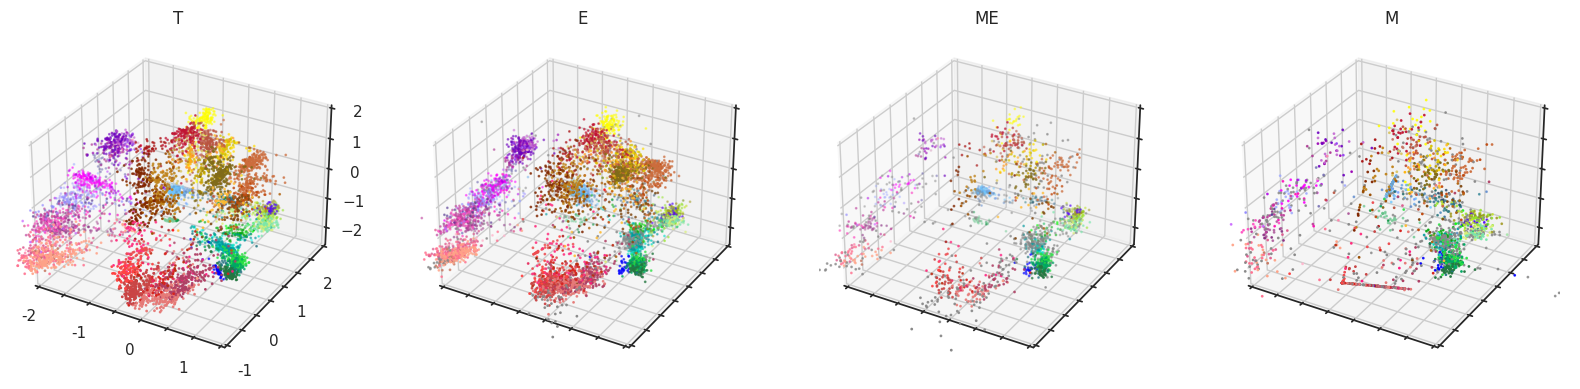

In [55]:
folder = "/home/fahimehb/Local/new_codes/cplAE_MET/data/results/all_connected_ME_cells_Edata_debugged_Mdata_zeroed_channels_v2"
file= "checkpoint_ep_40000_test.pkl"
path = os.path.join(folder, file)
output = loadpkl(path) 
plot_z_3d(output, xlim=(-2, 1.5), ylim=(-1, 2.5), zlim=(-2.5,2))

# folder = "/home/fahimehb/Local/new_codes/cplAE_MET/data/results/all_connected_ME_cells_Edata_debugged_Mdata_zeroed_channels_v1"
# file= "checkpoint_ep_40000_test.pkl"
# path = os.path.join(folder, file)
# output = loadpkl(path) 
# plot_z(output, xlim=(-2.5, 2.5), ylim=(-2.5, 2.5))


================================== original arbor density for an Exc cell =====================================


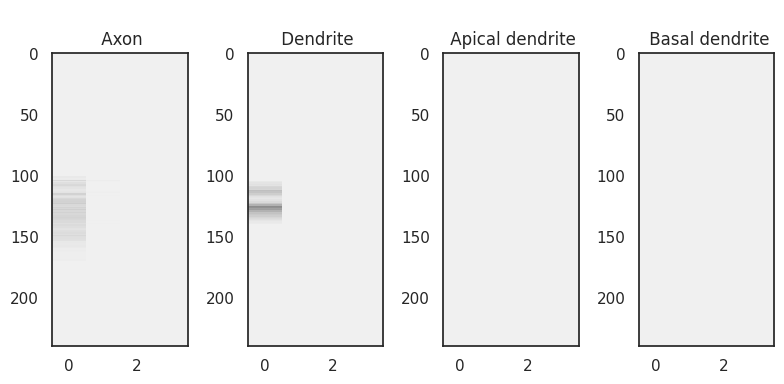

=============================== reconstructed arbor density for an Exc cell ===================================


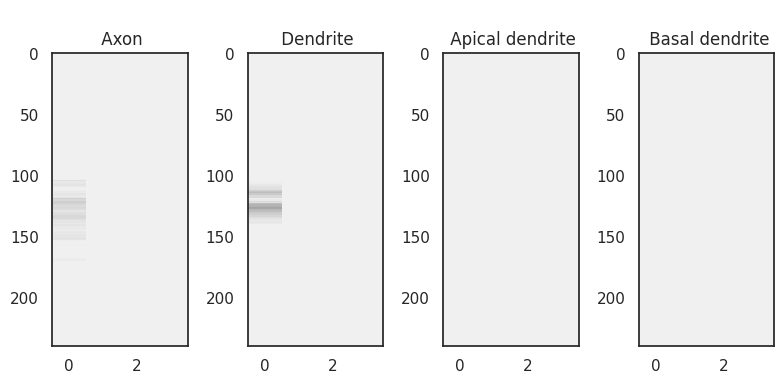

In [56]:
val_XM = output['XM'][val_ind, ...]
val_XrM = output['XrM'][val_ind, ...]
print()
print("================================== original arbor density for an Exc cell =====================================")
plot_m(val_XM[50, 0, ...])
print("=============================== reconstructed arbor density for an Exc cell ===================================")
plot_m(val_XrM[50, 0, ...])

In [57]:
npp = ["Vip", "Npy", "Sst", "Penk", "Tac2", "Cck", "Tac1", "Crh", "Pdyn", "Cort", "Pthlh","Pnoc",
 "Adcyap1", "Grp", "Nts", "Rln1", "Vipr1", "Npy1r", "Npy2r", "Npy5r", "Sstr1", "Sstr2", "Sstr4", 
 "Oprd1", "Oprm1", "Cckbr", "Crhr1", "Tacr1", "Oprl1", "Adcyap1r1", "Trhr", "Nmbr", "Ntsr1", "Rxfp1", "Rxfp3"]
npp_ids = [output['gene_ids'].tolist().index(i) for i in npp]

In [60]:


model_config = dict(latent_dim=3,
                        batch_size=1000,
                        augment_decoders=0,
                        T=dict(dropout_p=0.2, 
                               alpha_T=1),
                        E=dict(gnoise_std=0,
                               gnoise_std_frac=0.05, 
                               dropout_p=0.2, 
                               alpha_E=1),
                        M=dict(gnoise_std_frac=0.1,
                               scale_by=0.3, 
                               interpolation_mode="nearest",
                               random=True,
                               alpha_M=1,
                               alpha_sd=1),
                        TE=dict(lambda_TE=1, lambda_tune_T_E=1, lambda_tune_E_T=0),
                        TM=dict(lambda_TM=1, lambda_tune_T_M=1, lambda_tune_M_T=0),
                        ME=dict(alpha_ME=1, lambda_ME=1, lambda_tune_M_E=0,lambda_tune_E_M=1),
                        ME_T=dict(lambda_ME_T=1, lambda_tune_ME_T=0.1, lambda_tune_T_ME=0.9),
                        ME_M=dict(lambda_ME_M=1, lambda_tune_ME_M=1, lambda_tune_M_ME=0), 
                        ME_E=dict(lambda_ME_E=1, lambda_tune_ME_E=1, lambda_tune_E_ME=0),
                        )

loaded_model = torch.load("/home/fahimehb/Local/new_codes/cplAE_MET/data/results/all_connected_ME_cells_Edata_debugged_Mdata_zeroed_channels_v2/checkpoint_ep_40000_test.pt", map_location='cpu')
model = Model_ME_T(model_config)
model.load_state_dict(loaded_model['state_dict'])
model.eval()


zm = torch.tensor(output['zm'])
ze = torch.tensor(output['ze'])
zme = torch.tensor(output['zme_paired'])

XrT_from_zm_val = tonumpy(model.ae_t.dec_zt_to_xt(zm)[val_ind])
XrT_from_ze_val = tonumpy(model.ae_t.dec_zt_to_xt(ze)[val_ind])
XrT_from_zme_val = tonumpy(model.ae_t.dec_zt_to_xt(zme)[val_ind])
XrT_val = output['XrT'][val_ind]

XrT_from_zm_val = pd.DataFrame(XrT_from_zm_val[:,npp_ids], columns=npp)
XrT_from_ze_val = pd.DataFrame(XrT_from_ze_val[:,npp_ids], columns=npp)
XrT_from_zme_val = pd.DataFrame(XrT_from_zme_val[:,npp_ids], columns=npp)
XrT_val = pd.DataFrame(XrT_val[:, npp_ids], columns=npp)

XT_val =output['XT'][val_ind]
XT_val = pd.DataFrame(XT_val[:, npp_ids], columns=npp)

XrT_from_zm_val = XrT_from_zm_val!=0
XrT_from_ze_val = XrT_from_ze_val!=0
XrT_from_zme_val = XrT_from_zme_val!=0
XrT_val = XrT_val!=0
XT_val = XT_val!=0

Expression_prediction_T = (XrT_val == XT_val).mean()
Expression_prediction_E = (XrT_from_ze_val == XT_val).mean()
Expression_prediction_ME = (XrT_from_zme_val == XT_val).mean()
Expression_prediction_M = (XrT_from_zm_val == XT_val).mean()

def return_ind_sorted_list(a_list):
    indices = sorted(
        range(len(a_list)),
        key=lambda index: a_list[index]
    )
    return indices

sort = return_ind_sorted_list(Expression_prediction_T)
sort.reverse()

In [68]:
binary_npp_exp = output['XT'][train_ind]
binary_npp_exp = binary_npp_exp[:, npp_ids]!=0
frac_cells = binary_npp_exp.mean(axis=0)
relative_abundance= [max(i, 1-i) for i in frac_cells]

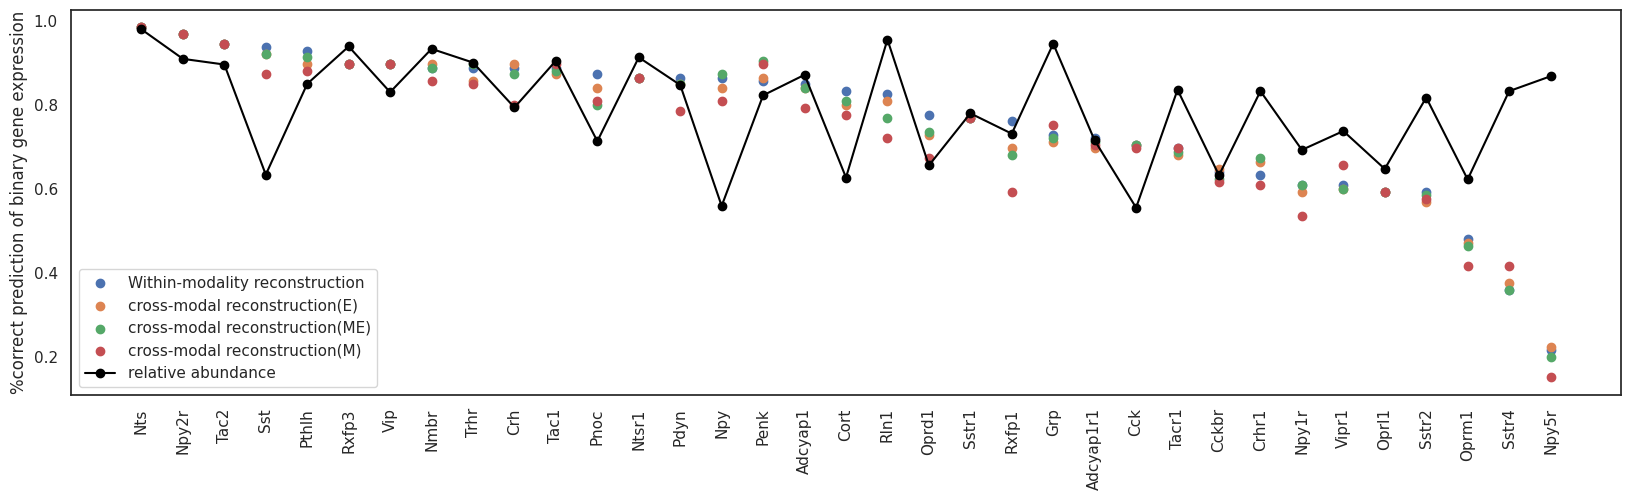

In [71]:
plt.figure(figsize=(20,5))
plt.scatter(range(len(npp)),[Expression_prediction_T[i] for i in sort], label="Within-modality reconstruction")
plt.scatter(range(len(npp)), [Expression_prediction_E[i] for i in sort], label="cross-modal reconstruction(E)")
plt.scatter(range(len(npp)), [Expression_prediction_ME[i] for i in sort], label="cross-modal reconstruction(ME)")
plt.scatter(range(len(npp)), [Expression_prediction_M[i] for i in sort], label="cross-modal reconstruction(M)")
plt.plot([i for i in range(len(npp))], [relative_abundance[j] for j in sort], '-o', color="black", label="relative abundance")

plt.xticks(range(len(npp)),[npp[i] for i in sort], rotation=90)
plt.ylabel("%correct prediction of binary gene expression")

plt.legend()

In [5]:
from collections import Counter
cldf = pd.DataFrame({"cluster_id":output['cluster_id'], "cluster_label":output['cluster_label'], "cluster_color":output['cluster_color']})
cldf = cldf.drop_duplicates()
cldf = cldf[cldf['cluster_label']!="NA"]
cldf = cldf.sort_values(by=["cluster_id"])

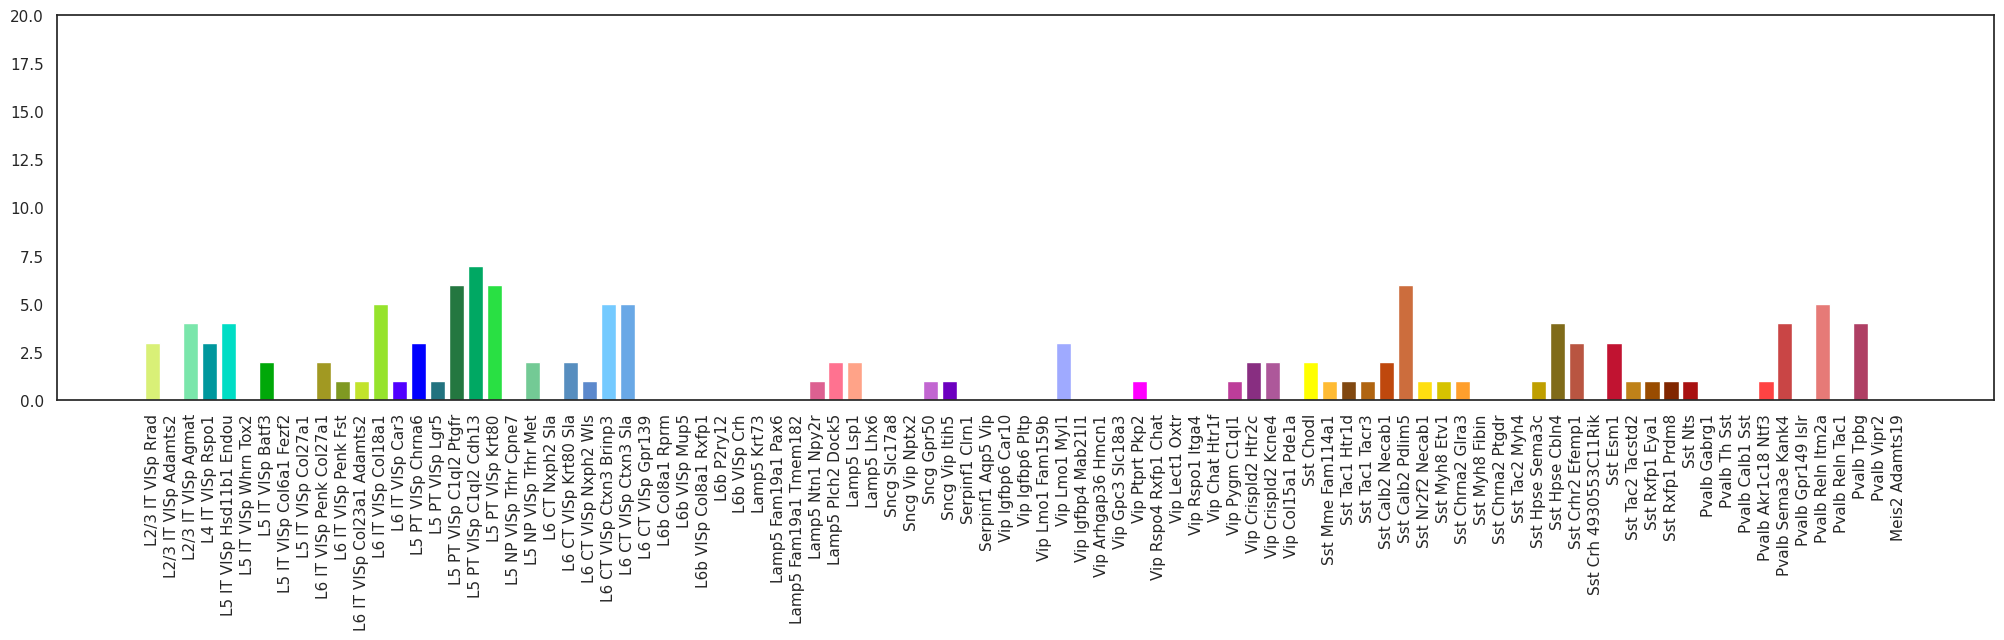

In [ ]:
cell_type_dist = Counter(output['cluster_label'][val_ind])
for c in cldf.cluster_label.to_list():
    if c not in cell_type_dist.keys():
        cell_type_dist[c] = 0
lists = cell_type_dist.items() # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples
x = list(x)
y = list(y)
ordered_ind = [x.index(i) for  i in cldf['cluster_label'].to_list() if i in x]
x = np.array(x)[ordered_ind]
y = np.array(y)[ordered_ind]
color = [cldf[cldf['cluster_label']==c]['cluster_color'].tolist()[0] for c in x]

fig = plt.figure(figsize=(25,5))

plt.bar(x, y, color=color)
# plt.scatter(x, y)

plt.xticks(range(len(x)),x, rotation=90)
plt.ylim(0,20)


plt.show()

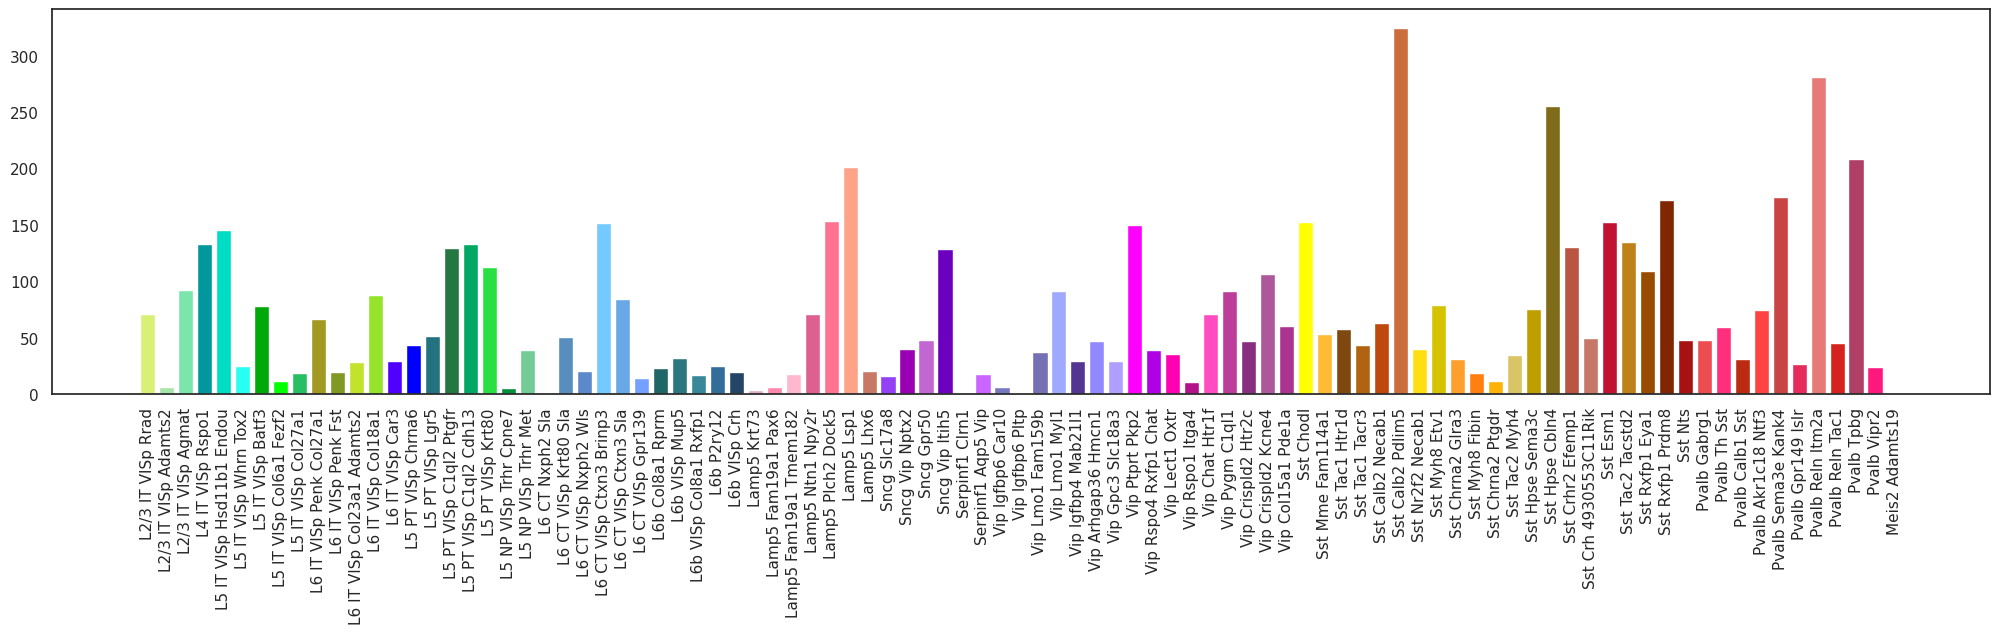

In [ ]:
cell_type_dist = Counter(output['cluster_label'][train_ind])
del cell_type_dist['NA']
lists = cell_type_dist.items() # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples
x = list(x)
y = list(y)
ordered_ind = [x.index(i) for  i in cldf['cluster_label'].to_list() if i in x]
x = np.array(x)[ordered_ind]
y = np.array(y)[ordered_ind]
color = [cldf[cldf['cluster_label']==c]['cluster_color'].tolist()[0] for c in x]

fig = plt.figure(figsize=(25,5))
plt.bar(x, y, color= color)

plt.xticks(range(len(x)),x, rotation=90)

plt.show()